In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV

## 1. Data



In [344]:
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

In [345]:
n_samples, n_features = X_train.shape
print('Les données d\'entraînement contiennent : {} échantillons de dimension {}'.format(n_samples, n_features))
print('Les données de test contiennent : {} échantillons de dimension {}'.format(X_test.shape[0], X_test.shape[1]))

Les données d'entraînement contiennent : 1494 échantillons de dimension 35
Les données de test contiennent : 654 échantillons de dimension 35


### Description des données

In [346]:
with pd.option_context('display.max_columns', None):
    display(X_train.head())

ID  DAY_ID COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  \
0  1054     206      FR        0.210099       -0.427458       -0.606523   
1  2049     501      FR       -0.022399       -1.003452       -0.022063   
2  1924     687      FR        1.395035        1.978665        1.021305   
3   297     720      DE       -0.983324       -0.849198       -0.839586   
4  1101     818      FR        0.143807       -0.617038       -0.924990   

   FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  FR_NET_IMPORT  \
0        0.606523            NaN       0.692860            NaN      -0.692860   
1        0.022063      -0.573520      -1.130838       0.573520       1.130838   
2       -1.021305      -0.622021      -1.682587       0.622021       1.682587   
3        0.839586      -0.270870       0.563230       0.270870      -0.563230   
4        0.924990            NaN       0.990324            NaN      -0.990324   

     DE_GAS    FR_GAS   DE_COAL   FR_COAL  DE_HYDRO  FR_HYDRO  DE_NUCLEAR  \
0  0.441238 -0.213766  0.740627  0.288782  2.209047  0.207838    0.709614   
1  0.174773  0.426940 -0.170392 -0.762153  0.187964 -0.807112   -1.882740   
2  2.351913  2.122241  1.572267  0.777053 -0.108578  0.779142   -1.897109   
3  0.487818  0.194659 -1.473817 -0.786025 -0.368417  1.320483   -0.205547   
4  0.238693 -0.240862  1.003734 -0.274975 -0.230179 -0.795983   -0.005581   

   FR_NUCLEAR  DE_SOLAR  FR_SOLAR  DE_WINDPOW  FR_WINDPOW  DE_LIGNITE  \
0   -0.190463  0.101766  1.248911   -0.573370   -0.269460    0.870344   
1   -2.185961  1.987428  3.237380   -0.035514   -0.107350   -0.194308   
2    0.735137 -1.115583 -0.371039   -0.298755   -0.141239    0.428272   
3   -1.589554  1.751523  0.562944   -0.010090    0.366885   -2.330557   
4    0.176935  0.693543  0.723587   -0.774941   -0.564498    0.691040   

   DE_RESIDUAL_LOAD  FR_RESIDUAL_LOAD   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND  \
0          0.626666         -0.444661 -0.172680 -0.556356 -0.790823 -0.283160   
1         -0.395469         -1.183194 -1.240300 -0.770457  1.522331  0.828412   
2          1.336625          1.947273 -0.480700 -0.313338  0.431134  0.487608   
3         -1.191889         -0.976974 -1.114838 -0.507570 -0.499409 -0.236249   
4          0.571613         -0.526267 -0.541465 -0.424550 -1.088158 -1.011560   

    DE_TEMP   FR_TEMP   GAS_RET  COAL_RET  CARBON_RET  
0 -1.069070 -0.063404  0.339041  0.124552   -0.002445  
1  0.437419  1.831241 -0.659091  0.047114   -0.490365  
2  0.684884  0.114836  0.535974  0.743338    0.204952  
3  0.350938 -0.417514  0.911652 -0.296168    1.073948  
4  0.614338  0.729495  0.245109  1.526606    2.614378

In [347]:
y_train.head()

ID    TARGET
0  1054  0.028313
1  2049 -0.112516
2  1924 -0.180840
3   297 -0.260356
4  1101 -0.071733

Les données d'entrée possèdent 35 colonnes :

- ID : Identifiant d'indexe unique, associé à un jour (DAY_ID) et un pays (COUNTRY),
- DAY_ID : Identifiant du jour - les dates ont été annonymisées en préservant la structure des données,
- COUNTRY : Identifiant du pays - DE = Allemagne, FR = France, 

et composées ensuite de variations journalières du prix de matières premières,

- GAS_RET : Gaz en Europe,
- COAL_RET : Charbon en Europe,
- CARBON_RET : Futures sur les emissions carbone, 

de mesures météorologiques (journalières, dans le pays x),

- x_TEMP : Temperature,
- x_RAIN : Pluie,
- x_WIND : Vent,

de mesures de productions d'energie (journalière, dans le pays x),

- x_GAS : Gaz naturel,
- x_COAL : Charbon,
- x_HYDRO : Hydrolique,
- x_NUCLEAR : Nucléaire,
- x_SOLAR : Photovoltaïque,
- x_WINDPOW : Eolienne,
- x_LIGNITE : Lignite,

et de mesures d'utilisation électrique (journalières, dans le pays x),

- x_CONSUMPTON : Electricité totale consommée,
- x_RESIDUAL_LOAD : Electricité consommée après utilisation des énergies renouvelables,
- x_NET_IMPORT: Electricité importée depuis l'Europe,
- x_NET_EXPORT: Electricité exportée vers l'Europe,
- DE_FR_EXCHANGE: Electricité échangée entre Allemagne et France,
- FR_DE_EXCHANGE: Electricité échangée entre France et Allemagne.



#### Commentaires:
- Dans le benchmarck FR et DE sont traités de la même facon. Vaut-il mieux les traiter séparamment.
- Si nous construisons deux modèles distincts, alors le dataset perdra considérablement en terme de qualité. En effet nous diviserons presque par deux le nombre d'observations pour chaque modèle
- Il faudrait donc améliorer le jeu de données pour pouvoir construire un unique modèle de prédiction qualitatif.

In [348]:
X_train["DAY_ID"].value_counts().head(1000)


DAY_ID
77      2
237     2
231     2
1001    2
1070    2
       ..
0       1
308     1
721     1
969     1
90      1
Name: count, Length: 851, dtype: int64

In [349]:
day_ids = [77, 237, 231, 1001, 1070, 1112, 908, 757, 542, 391]

X_train[X_train["DAY_ID"].isin(day_ids)].sort_values("DAY_ID")


ID  DAY_ID COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  \
492   1278      77      FR        0.204839       -0.556874       -0.868887   
852     62      77      DE        0.204839       -0.556874       -0.868887   
550   2060     231      FR       -0.511138       -0.802438        0.938683   
1212   844     231      DE       -0.511138       -0.802438        0.938683   
561   1363     237      FR        0.664205        0.326647       -0.213652   
567    147     237      DE        0.664205        0.326647       -0.213652   
560   2050     391      FR       -0.305770       -0.818128        0.397849   
1364   834     391      DE       -0.305770       -0.818128        0.397849   
559    646     542      DE        1.166555       -0.318736       -0.243236   
960   1862     542      FR        1.166555       -0.318736       -0.243236   
904    675     757      DE        2.033851        1.914500        1.215698   
558   1891     757      FR        2.033851        1.914500        1.215698   
1170   582     908      DE        0.099163       -0.541148       -0.127704   
1428  1798     908      FR        0.099163       -0.541148       -0.127704   
778    607    1001      DE        0.125008       -0.816226       -0.438063   
551   1823    1001      FR        0.125008       -0.816226       -0.438063   
554    785    1070      DE        0.073717       -0.755642        0.051299   
924   2001    1070      FR        0.073717       -0.755642        0.051299   
555    550    1112      DE        0.170837       -0.746076       -0.767485   
1425  1766    1112      FR        0.170837       -0.746076       -0.767485   

      FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  ...  \
492         0.868887      -0.923998       0.858085       0.923998  ...   
852         0.868887      -0.923998       0.858085       0.923998  ...   
550        -0.938683      -0.723702      -2.174215       0.723702  ...   
1212       -0.938683      -0.723702      -2.174215       0.723702  ...   
561         0.213652      -0.027239      -0.462336       0.027239  ...   
567         0.213652      -0.027239      -0.462336       0.027239  ...   
560        -0.397849      -0.299681      -1.494674       0.299681  ...   
1364       -0.397849      -0.299681      -1.494674       0.299681  ...   
559         0.243236       0.976377       0.877926      -0.976377  ...   
960         0.243236       0.976377       0.877926      -0.976377  ...   
904        -1.215698       1.614471      -1.592028      -1.614471  ...   
558        -1.215698       1.614471      -1.592028      -1.614471  ...   
1170        0.127704      -1.526359       0.819463       1.526359  ...   
1428        0.127704      -1.526359       0.819463       1.526359  ...   
778         0.438063      -0.125344       1.112040       0.125344  ...   
551         0.438063      -0.125344       1.112040       0.125344  ...   
554        -0.051299      -0.894242      -0.892780       0.894242  ...   
924        -0.051299      -0.894242      -0.892780       0.894242  ...   
555         0.767485      -1.178246       1.092143       1.178246  ...   
1425        0.767485      -1.178246       1.092143       1.178246  ...   

      FR_RESIDUAL_LOAD   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND   DE_TEMP  \
492          -0.606544 -1.316356 -0.173395 -0.419634 -0.195610 -1.597233   
852          -0.606544 -1.316356 -0.173395 -0.419634 -0.195610 -1.597233   
550          -0.779227 -1.516457 -0.478945  0.909630  0.100861  0.171330   
1212         -0.779227 -1.516457 -0.478945  0.909630  0.100861  0.171330   
561           0.349165  0.045906 -0.739773 -0.849181 -0.669926 -0.193674   
567           0.349165  0.045906 -0.739773 -0.849181 -0.669926 -0.193674   
560          -0.997108 -0.450657 -0.108242  1.390915  1.370472 -0.380167   
1364         -0.997108 -0.450657 -0.108242  1.390915  1.370472 -0.380167   
559          -1.091336 -0.420718 -0.471684  2.543151  3.499060  1.297569   
960          -1.091336 -0.420718 -0.471684  2.543151  

In [350]:
y_train.loc[[1278, 62]]

ID    TARGET
1278   878 -0.444789
62    1560 -0.532471

#### Commentaires 
- On observe que les features de certaines dates sont utilisés deux fois dans le dataset : une fois pour décrire la Variation du prix de l'électricté en France, et l'autre fois pour décrire celle en Allemagne
- On observe aussi que les même feautures  ont des impacts totalement différents sur la variation du prix de l'éléctricité en Allemagne ou en France. Il serait donc judicieux de bien préparer le set de données avant de passer à la modélisation.
- Une solution serait de modifier COUNTRY en une variable binaire prenant des valeurs {0,1}.

Nous allons procéder à pré-traitement du dataset

In [351]:
# concatener x_train et y_train pour avoir toutes les données ensemble
import pandas as pd

X= X_train.merge(
    y_train[["ID", "TARGET"]],
    on="ID",
    how="inner"
)


### Les valeurs manquantes
- Pour les données numériques, nous souhaitons remplacer les données manquantes avec la méthode ffil. Cette méthode nécessite d'uiliser des séries temporelles, il faut donc trier les données par ordre chronologique. POur cela nous allons séparer le dataset en deux : les variations allemandes et françaises, puis au sein de ces deux datasets nous trirons les données dans le l'ordre chronologique, puis nous appliquerons la méthode "ffill".
- De plus pour la colonne "COUNTRY" nous allons la rendre binaire.

In [352]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [353]:
with pd.option_context('display.max_columns', None):
    display(X_train.isna().sum())

ID                    0
DAY_ID                0
COUNTRY               0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       25
FR_DE_EXCHANGE       25
DE_NET_EXPORT       124
FR_NET_EXPORT        70
DE_NET_IMPORT       124
FR_NET_IMPORT        70
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN              94
FR_RAIN              94
DE_WIND              94
FR_WIND              94
DE_TEMP              94
FR_TEMP              94
GAS_RET               0
COAL_RET              0
CARBON_RET            0
dtype: int64

In [354]:
numeric_features = ['GAS_RET',
                     'COAL_RET', 
                     'CARBON_RET',
                     'DE_TEMP',
                     'DE_RAIN',
                     'DE_WIND',
                     'DE_GAS',
                     'DE_COAL',
                     'DE_HYDRO',
                     'DE_NUCLEAR',
                     'DE_SOLAR',
                     'DE_WINDPOW',
                     'DE_LIGNITE',
                     'DE_CONSUMPTION',
                     'DE_RESIDUAL_LOAD',
                     'DE_NET_IMPORT',
                     'DE_NET_EXPORT',
                     'FR_TEMP',
                     'FR_RAIN',
                     'FR_WIND',
                     'FR_GAS',
                     'FR_COAL',
                     'FR_HYDRO',
                     'FR_NUCLEAR',
                     'FR_SOLAR',
                     'FR_WINDPOW',
                     'FR_CONSUMPTION',
                     'FR_RESIDUAL_LOAD',
                     'FR_NET_IMPORT',
                     'FR_NET_EXPORT',
                     'DE_FR_EXCHANGE',
                     'FR_DE_EXCHANGE']
categorical_features = ['COUNTRY']

In [355]:
X_DE = X[X['COUNTRY'] == 'DE']
X_FR = X[X['COUNTRY'] == 'FR']
X_DE_test= X_test[X_test['COUNTRY'] == 'DE']
X_FR_test= X_test[X_test['COUNTRY'] == 'FR']

print(f"Le dataset allemand comporte {len(X_DE)} échantillons.")
print(f"Le dataset français comporte {len(X_FR)} échantillons.")

Le dataset allemand comporte 643 échantillons.
Le dataset français comporte 851 échantillons.


In [356]:
# trier les datasets par ordre chronologique (DAY_ID)
X_DE = X_DE.sort_values("DAY_ID")
X_FR = X_FR.sort_values("DAY_ID")
X_DE_test = X_DE_test.sort_values("DAY_ID")
X_FR_test = X_FR_test.sort_values("DAY_ID")

# POur les features numériques : Appliquer forward fill, et 0 si première valeur
X_DE[numeric_features] = X_DE[numeric_features].fillna(method='ffill').fillna(0)
X_FR[numeric_features] = X_FR[numeric_features].fillna(method='ffill').fillna(0)
X_DE_test[numeric_features] = X_DE_test[numeric_features].fillna(method='ffill').fillna(0)
X_FR_test[numeric_features] = X_FR_test[numeric_features].fillna(method='ffill').fillna(0)

X_train = pd.concat([X_DE, X_FR])
X_test= pd.concat([X_DE_test, X_FR_test])

X_train["COUNTRY"] = (X_train["COUNTRY"] == "FR").astype(int) # FR=1, DE=0
X_test["COUNTRY"] = (X_test["COUNTRY"] == "FR").astype(int) # FR=1, DE=0



/var/folders/kz/jrt48myn5lv2h550w8pl7qvm0000gn/T/ipykernel_46778/1758424654.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_DE[numeric_features] = X_DE[numeric_features].fillna(method='ffill').fillna(0)
/var/folders/kz/jrt48myn5lv2h550w8pl7qvm0000gn/T/ipykernel_46778/1758424654.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_FR[numeric_features] = X_FR[numeric_features].fillna(method='ffill').fillna(0)
/var/folders/kz/jrt48myn5lv2h550w8pl7qvm0000gn/T/ipykernel_46778/1758424654.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_DE_test[numeric_features] = X_DE_test[numeric_features].fillna(method='ffill').fillna(0)
/var/folders/kz/jrt48myn5lv2h550w8pl7qvm0000gn/T/ipykernel_46778/1758424654.py:11: Fut

In [357]:
with pd.option_context('display.max_columns', None):
    display(X_train.head())


ID  DAY_ID  COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  \
1468  111       2        0       -0.068972       -0.667390       -1.102015   
680   800       3        0       -0.134670       -0.834564       -1.051716   
991   831       5        0       -0.297850       -0.470371        0.144615   
1356  779       7        0        0.057599       -0.625625        0.002239   
713   841       8        0       -0.282744       -0.700027        1.309253   

      FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  \
1468        1.102015      -1.080403       0.256736       1.080403   
680         1.051716      -1.881881      -0.612133       1.881881   
991        -0.144615      -1.208286      -1.811403       1.208286   
1356       -0.002239      -0.676226      -0.745182       0.676226   
713        -1.309253       0.248085      -2.226840      -0.248085   

      FR_NET_IMPORT    DE_GAS    FR_GAS   DE_COAL   FR_COAL  DE_HYDRO  \
1468      -0.256736  1.228079  0.458302 -0.247704 -0.766904  1.785758   
680        0.612133  1.588542  0.069297 -0.635452 -0.718729  1.994144   
991        1.811403  1.059828  0.528273 -0.072071 -0.766063  1.275857   
1356       0.745182  0.386191  0.727314  0.255380 -0.778036  0.281094   
713        2.226840  0.955400  0.278566 -0.234473 -0.755877  0.385716   

      FR_HYDRO  DE_NUCLEAR  FR_NUCLEAR  DE_SOLAR  FR_SOLAR  DE_WINDPOW  \
1468 -0.930172    0.064726   -0.379230 -0.187892  1.032412   -0.421844   
680  -0.383690   -2.002323   -1.579208  1.527633  2.986527   -1.142488   
991  -0.398178   -1.875681   -1.866010  2.551925  3.425813   -0.892244   
1356 -0.739291   -1.887303   -1.934168  1.654025  2.276123   -0.876909   
713  -0.580103   -1.889094   -2.414937  1.267943  2.554835    0.274719   

      FR_WINDPOW  DE_LIGNITE  DE_RESIDUAL_LOAD  FR_RESIDUAL_LOAD   DE_RAIN  \
1468   -0.844350   -0.471366          0.398812         -0.540642 -0.344600   
680    -0.718643   -0.169336          0.275487         -0.856321 -1.394561   
991    -0.640389   -0.279690         -0.031595         -0.552878 -1.374757   
1356   -0.079343    0.108801          0.142427         -0.806379 -0.531862   
713    -0.318923   -0.245104         -0.508221         -0.791016  1.522720   

       FR_RAIN   DE_WIND   FR_WIND   DE_TEMP   FR_TEMP   GAS_RET  COAL_RET  \
1468 -0.372156 -0.623041 -0.926064 -0.148950  0.641235  1.802550  1.140920   
680  -1.118297  0.244859  0.488650 -1.710888 -0.951057  0.440121 -0.064550   
991  -0.790071  0.333817  0.021868 -0.062187  1.459745 -0.117977  0.550433   
1356 -0.663419  0.098940  1.367421 -0.812164  0.954384 -0.379980  0.518459   
713  -0.307449  1.690497  1.584210 -0.441943 -0.382423  1.557325  0.146634   

      CARBON_RET    TARGET  
1468    0.900434  0.861270  
680    -0.032756  7.138604  
991     0.781870  0.026374  
1356   -0.034642 -0.021227  
713     2.329924  0.042996

In [358]:
X_train.isna().sum()

ID                  0
DAY_ID              0
COUNTRY             0
DE_CONSUMPTION      0
FR_CONSUMPTION      0
DE_FR_EXCHANGE      0
FR_DE_EXCHANGE      0
DE_NET_EXPORT       0
FR_NET_EXPORT       0
DE_NET_IMPORT       0
FR_NET_IMPORT       0
DE_GAS              0
FR_GAS              0
DE_COAL             0
FR_COAL             0
DE_HYDRO            0
FR_HYDRO            0
DE_NUCLEAR          0
FR_NUCLEAR          0
DE_SOLAR            0
FR_SOLAR            0
DE_WINDPOW          0
FR_WINDPOW          0
DE_LIGNITE          0
DE_RESIDUAL_LOAD    0
FR_RESIDUAL_LOAD    0
DE_RAIN             0
FR_RAIN             0
DE_WIND             0
FR_WIND             0
DE_TEMP             0
FR_TEMP             0
GAS_RET             0
COAL_RET            0
CARBON_RET          0
TARGET              0
dtype: int64

notes Tania : je pense que le onehot encoder n'est pas necessaire puisque on a juste 2 type de données. aussi il n'ya pas de NA pour la variable country

### Feature ingenering 

In [359]:
X_train['DAY_ID'].describe()

count    1494.000000
mean      591.861446
std       345.065043
min         0.000000
25%       292.250000
50%       591.000000
75%       885.750000
max      1215.000000
Name: DAY_ID, dtype: float64

In [360]:
X_test['DAY_ID'].describe()

count     654.000000
mean      632.744648
std       356.751037
min         4.000000
25%       334.000000
50%       633.500000
75%       952.000000
max      1214.000000
Name: DAY_ID, dtype: float64

Les jours vont de 0 à 1215 on ne peut pas faire grand chose, on ne peut pas creer de variables weekly. Cependant on peut essayer de creer des time block.

In [361]:
X_train["time_block"] = pd.qcut(X_train["DAY_ID"], q=4, labels=False)
X_test["time_block"] = pd.qcut(X_test["DAY_ID"], q=4, labels=False)



#### variations journalières du prix de matières premières

les variations jouranlieres brut des matieres premieres sont tres bruités. Il est recommandé dans les papiers (Weron (2014) – Electricity price forecasting) les regime indicators sur fuel prices. on calcule d'baord une moyenne mobile sur 7 jours puis on calcul puis on separe en 3 quantiles : "low", "medium", "high"

In [362]:
X_train = X_train.sort_values(["COUNTRY", "DAY_ID"])
X_train["GAS_RET_MA_7"] = (
    X_train.groupby("COUNTRY")["GAS_RET"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)
X_train["COAL_RET_MA_7"] = (
    X_train.groupby("COUNTRY")["COAL_RET"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)
X_train["CARBON_RET_MA_7"] = (
    X_train.groupby("COUNTRY")["CARBON_RET"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)
X_test = X_test.sort_values(["COUNTRY", "DAY_ID"])
X_test["GAS_RET_MA_7"] = (
    X_test.groupby("COUNTRY")["GAS_RET"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)
X_test["COAL_RET_MA_7"] = (
    X_test.groupby("COUNTRY")["COAL_RET"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).
mean()))
X_test["CARBON_RET_MA_7"] = (
    X_test.groupby("COUNTRY")["CARBON_RET"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)


on separe les regime indicators apres avoir fait le split test/val pour ne pas avoir de fuite

#### mesure de production

les interaction meteo x production sont tres influents sur le prix de l'electrcité. Un jour très venteux avec beaucoup d’éolien=prix plus bas. un jour venteux mais peu d’éolien = effet faible (Ziel & Weron (2018), Gianfreda et al. (2016))

In [363]:
# interactions vent × éolien
X_train["DE_WIND_WINDPOW"] = X_train["DE_WIND"] * X_train["DE_WINDPOW"]
X_train["FR_WIND_WINDPOW"] = X_train["FR_WIND"] * X_train["FR_WINDPOW"]

# température × residual load
X_train["DE_TEMP_RESLOAD"] = X_train["DE_TEMP"] * X_train["DE_RESIDUAL_LOAD"]

X_train["FR_TEMP_RESLOAD"] = X_train["FR_TEMP"] * X_train["FR_RESIDUAL_LOAD"]

# pluie × hydro
X_train["DE_RAIN_HYDRO"] = X_train["DE_RAIN"] * X_train["DE_HYDRO"]

X_train["FR_RAIN_HYDRO"] = X_train["FR_RAIN"] * X_train["FR_HYDRO"]


X_test["DE_WIND_WINDPOW"] = X_test["DE_WIND"] * X_test["DE_WINDPOW"]
X_test["FR_WIND_WINDPOW"] = X_test["FR_WIND"] * X_test["FR_WINDPOW"]
X_test["DE_TEMP_RESLOAD"] = X_test["DE_TEMP"] * X_test["DE_RESIDUAL_LOAD"]
X_test["FR_TEMP_RESLOAD"] = X_test["FR_TEMP"] * X_test["FR_RESIDUAL_LOAD"]
X_test["DE_RAIN_HYDRO"] = X_test["DE_RAIN"] * X_test["DE_HYDRO"]
X_test["FR_RAIN_HYDRO"] = X_test["FR_RAIN"] * X_test["FR_HYDRO"]


consommation

De meme l'interraction entre les exportations/importations et le residual load est important d'apres la litterature. Plus le residual load est élevé, plus le système est sous tension. residual load elevé + import net elevé ca veut dire que le pays n'arrive pas a produire suffisament = prix qui explose 

In [364]:
X_train["LOAD_IMPORT_FR"]=X_train["FR_RESIDUAL_LOAD"] * X_train['FR_NET_IMPORT']
X_train["LOAD_IMPORT_DE"]=X_train["DE_RESIDUAL_LOAD"] * X_train['DE_NET_IMPORT']
X_test["LOAD_IMPORT_FR"]=X_test["FR_RESIDUAL_LOAD"] * X_test['FR_NET_IMPORT']
X_test["LOAD_IMPORT_DE"]=X_test["DE_RESIDUAL_LOAD"] * X_test['DE_NET_IMPORT']


### Valeurs extrêmes

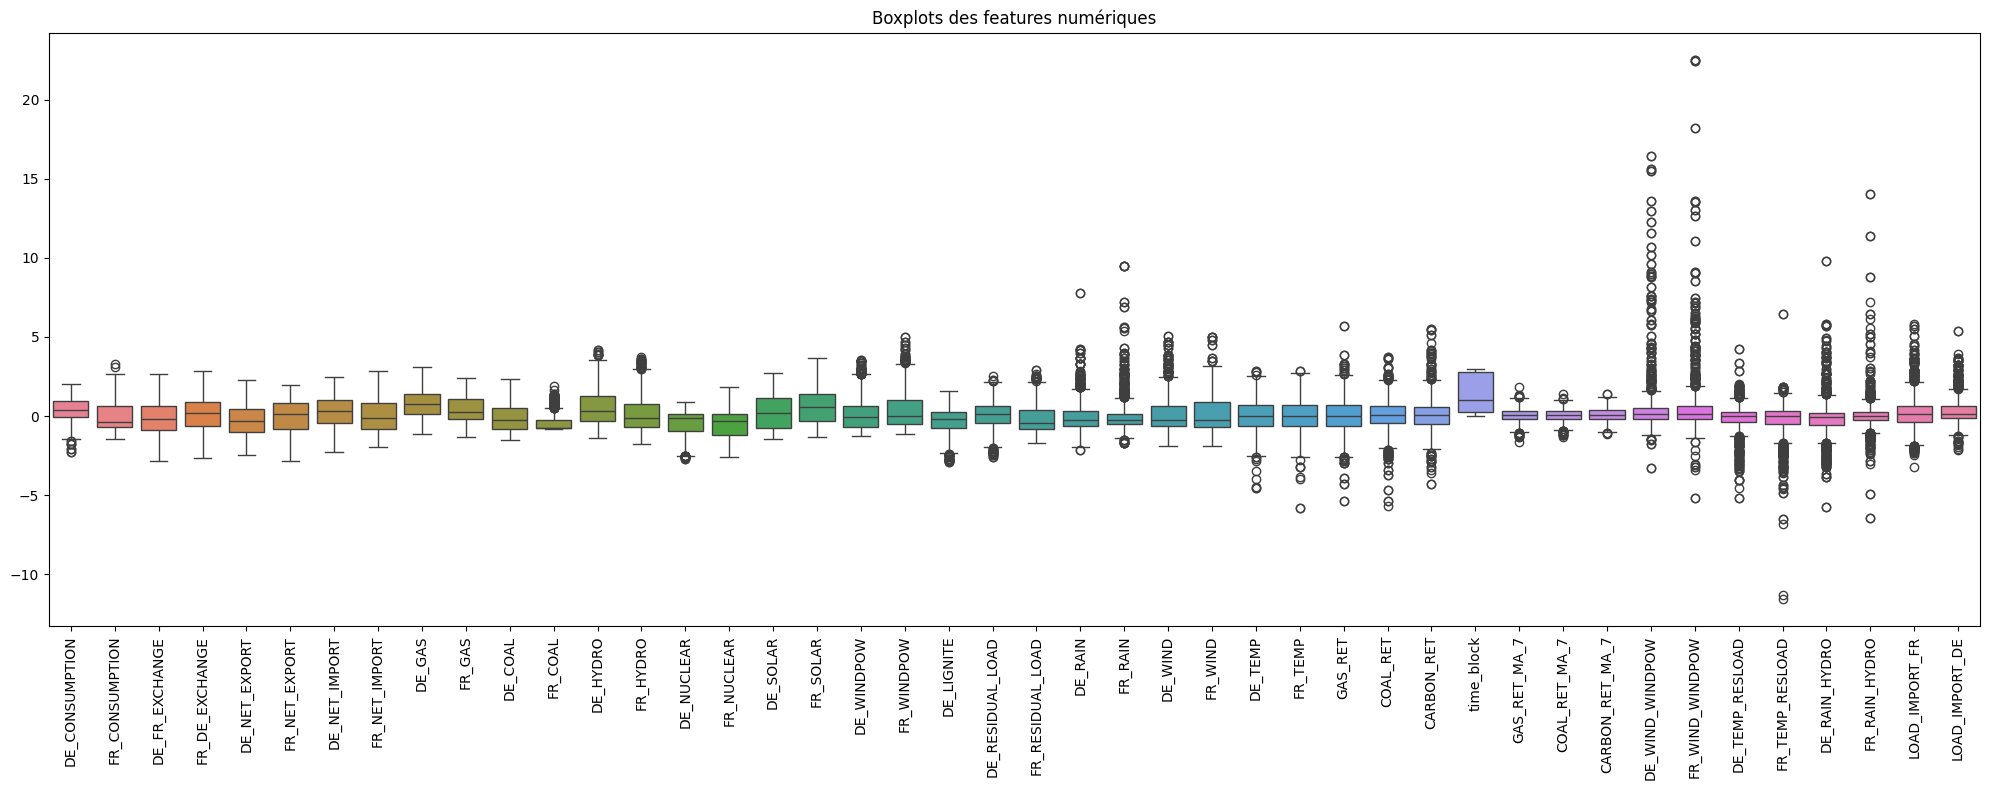

In [365]:
# Boxplot de toutes les features numériques sur un seul graphique
numeric_cols = X_train.drop(columns=categorical_features + ['ID', 'DAY_ID','TARGET'], errors='ignore')

plt.figure(figsize=(20, 8))
sns.boxplot(data=numeric_cols)
plt.xticks(rotation=90)
plt.title('Boxplots des features numériques')
plt.tight_layout()
plt.show()


#### Commentaires:
- Bien que plusieurs variables présentent des valeurs extrêmes, on ne les supprime pas. En effet, ces valeurs correspondent à des événements économiques et météorologiques réels (pics de prix de l’énergie, stress du réseau, conditions météorologiques exceptionnelles) et font partie intégrante du phénomène étudié. Les méthodes de détection d’outliers basées sur des hypothèses de normalité (telles que le Z-score) n’ont donc pas été retenues, afin d’éviter un biais d’échantillonnage et une perte d’information économiquement pertinente 

(cf papier Day-Ahead electricity price forecasting)

La seule exception ce serait les données meteorologiques. On verifie donc qu'il n'existe pas de valeurs impossibles

In [366]:
X[["FR_RAIN", "DE_RAIN", "FR_WIND",  "FR_TEMP", "DE_TEMP"]].describe()



FR_RAIN      DE_RAIN      FR_WIND      FR_TEMP      DE_TEMP
count  1400.000000  1400.000000  1400.000000  1400.000000  1400.000000
mean      0.019357    -0.037831     0.123099     0.008404     0.009451
std       1.051781     0.984233     1.054692     1.003356     0.972394
min      -1.726420    -2.128531    -1.895319    -5.787097    -4.549638
25%      -0.503927    -0.642117    -0.672614    -0.647948    -0.618259
50%      -0.228147    -0.274901    -0.229031    -0.020889    -0.026306
75%       0.154351     0.335237     0.824781     0.699131     0.651832
max       9.473201     7.756118     4.965028     2.817239     2.858758

les valeurs sont normales, il y'a pas de valeur extremes. on ne fait rien.

In [367]:
# Supprimer les valeurs extrêmes avec la méthode Z-score
#numeric_cols_names = X_train.drop(columns=categorical_features + ['ID', 'DAY_ID', 'COUNTRY_DE', 'COUNTRY_FR'], errors='ignore').columns
#z_scores = np.abs((X_train[numeric_cols_names] - X_train[numeric_cols_names].mean()) / X_train[numeric_cols_names].std())
#outlier_threshold = 3
#X = X[(z_scores <= outlier_threshold).all(axis=1)]

#print(f"Nombre d'échantillons après suppression des outliers : {len(X)}")

#y = y[y["ID"].isin(X["ID"])]

In [368]:
#numeric_cols = X.drop(columns=categorical_features + ['ID', 'DAY_ID', 'COUNTRY_DE', 'COUNTRY_FR'], errors='ignore')

#plt.figure(figsize=(20, 8))
#sns.boxplot(data=numeric_cols)
#plt.xticks(rotation=90)
#plt.title('Boxplots des features numériques, après suppression des outliers')
#plt.tight_layout()
#plt.show()


### Séparation du Dataset en deux jeux : Entraînement et Validation

In [369]:
y = X_train["TARGET"].copy()
X = X_train.drop(columns=["TARGET"]).copy()


On sépare notre jeux de données, tout en respectant la chronologie au sein des données allemandes et françaises. L'idée est de prédire le futur. On choisit un séparation 80% / 20%.

In [370]:

split_ratio = 0.8

X_tr_list, X_val_list = [], []
y_tr_list, y_val_list = [], []


#pour chaque pays 
for country_val in X["COUNTRY"].unique():
    X_c = X[X["COUNTRY"] == country_val].copy()
    #on recupere y correspondant
    y_c = y.loc[X_c.index].copy()

    # on s'assure d'un ordre temporel
    X_c = X_c.sort_values("DAY_ID")
    y_c = y_c.loc[X_c.index]

    # on split 
    days = np.sort(X_c["DAY_ID"].unique())
    cutoff_idx = int(len(days) * split_ratio)
    cutoff_day = days[cutoff_idx]

    train_mask = X_c["DAY_ID"] < cutoff_day
    val_mask   = X_c["DAY_ID"] >= cutoff_day

    X_tr_list.append(X_c.loc[train_mask])
    X_val_list.append(X_c.loc[val_mask])
    y_tr_list.append(y_c.loc[train_mask])
    y_val_list.append(y_c.loc[val_mask])

# on concatene les pays
X_tr = pd.concat(X_tr_list).sort_index()
X_val = pd.concat(X_val_list).sort_index()
y_tr = pd.concat(y_tr_list).sort_index()
y_val = pd.concat(y_val_list).sort_index()


In [371]:

#TARGET ne doit pas être dans X
assert "TARGET" not in X_tr.columns
assert "TARGET" not in X_val.columns

# Check dimensions cohérentes
assert len(X_tr) == len(y_tr)
assert len(X_val) == len(y_val)

# Check : les deux pays sont présents dans train et val
print("Train COUNTRY counts:\n", X_tr["COUNTRY"].value_counts())
print("Val   COUNTRY counts:\n", X_val["COUNTRY"].value_counts())

Train COUNTRY counts:
 COUNTRY
1    680
0    514
Name: count, dtype: int64
Val   COUNTRY counts:
 COUNTRY
1    171
0    129
Name: count, dtype: int64


on drop les id

In [372]:
X_tr = X_tr.drop(columns=["ID"], errors="ignore")
X_val = X_val.drop(columns=["ID"], errors="ignore")


### Feature enginnering (bis)

#### variations journalières du prix de matières premières

In [373]:
ma_cols = [
    "GAS_RET_MA_7",
    "COAL_RET_MA_7",
    "CARBON_RET_MA_7",
]

# Calcul des seuils de quantiles sur le jeu d'entraînement
regime_thresholds = {}
for col in ma_cols:
    q_low, q_high = X_tr[col].quantile([1/3, 2/3]).values
    regime_thresholds[col] = (q_low, q_high)

# Fonction pour ajouter les features de régime 3
def add_3regime_features(df: pd.DataFrame, thresholds: dict, suffix="_REG3") -> pd.DataFrame:
    df = df.copy()
    for col, (q_low, q_high) in thresholds.items():
        # returns 0 (low), 1 (mid), 2 (high)
        df[col + suffix] = pd.cut(
            df[col],
            bins=[-np.inf, q_low, q_high, np.inf],
            labels=[0, 1, 2],
            include_lowest=True
        ).astype(int)
    return df

# Ajouter les features de régime 3 aux jeux de données
X_tr  = add_3regime_features(X_tr,  regime_thresholds)
X_val = add_3regime_features(X_val, regime_thresholds)
X_test = add_3regime_features(X_test, regime_thresholds)

### La multicolinéarité

In [374]:
import seaborn as sns

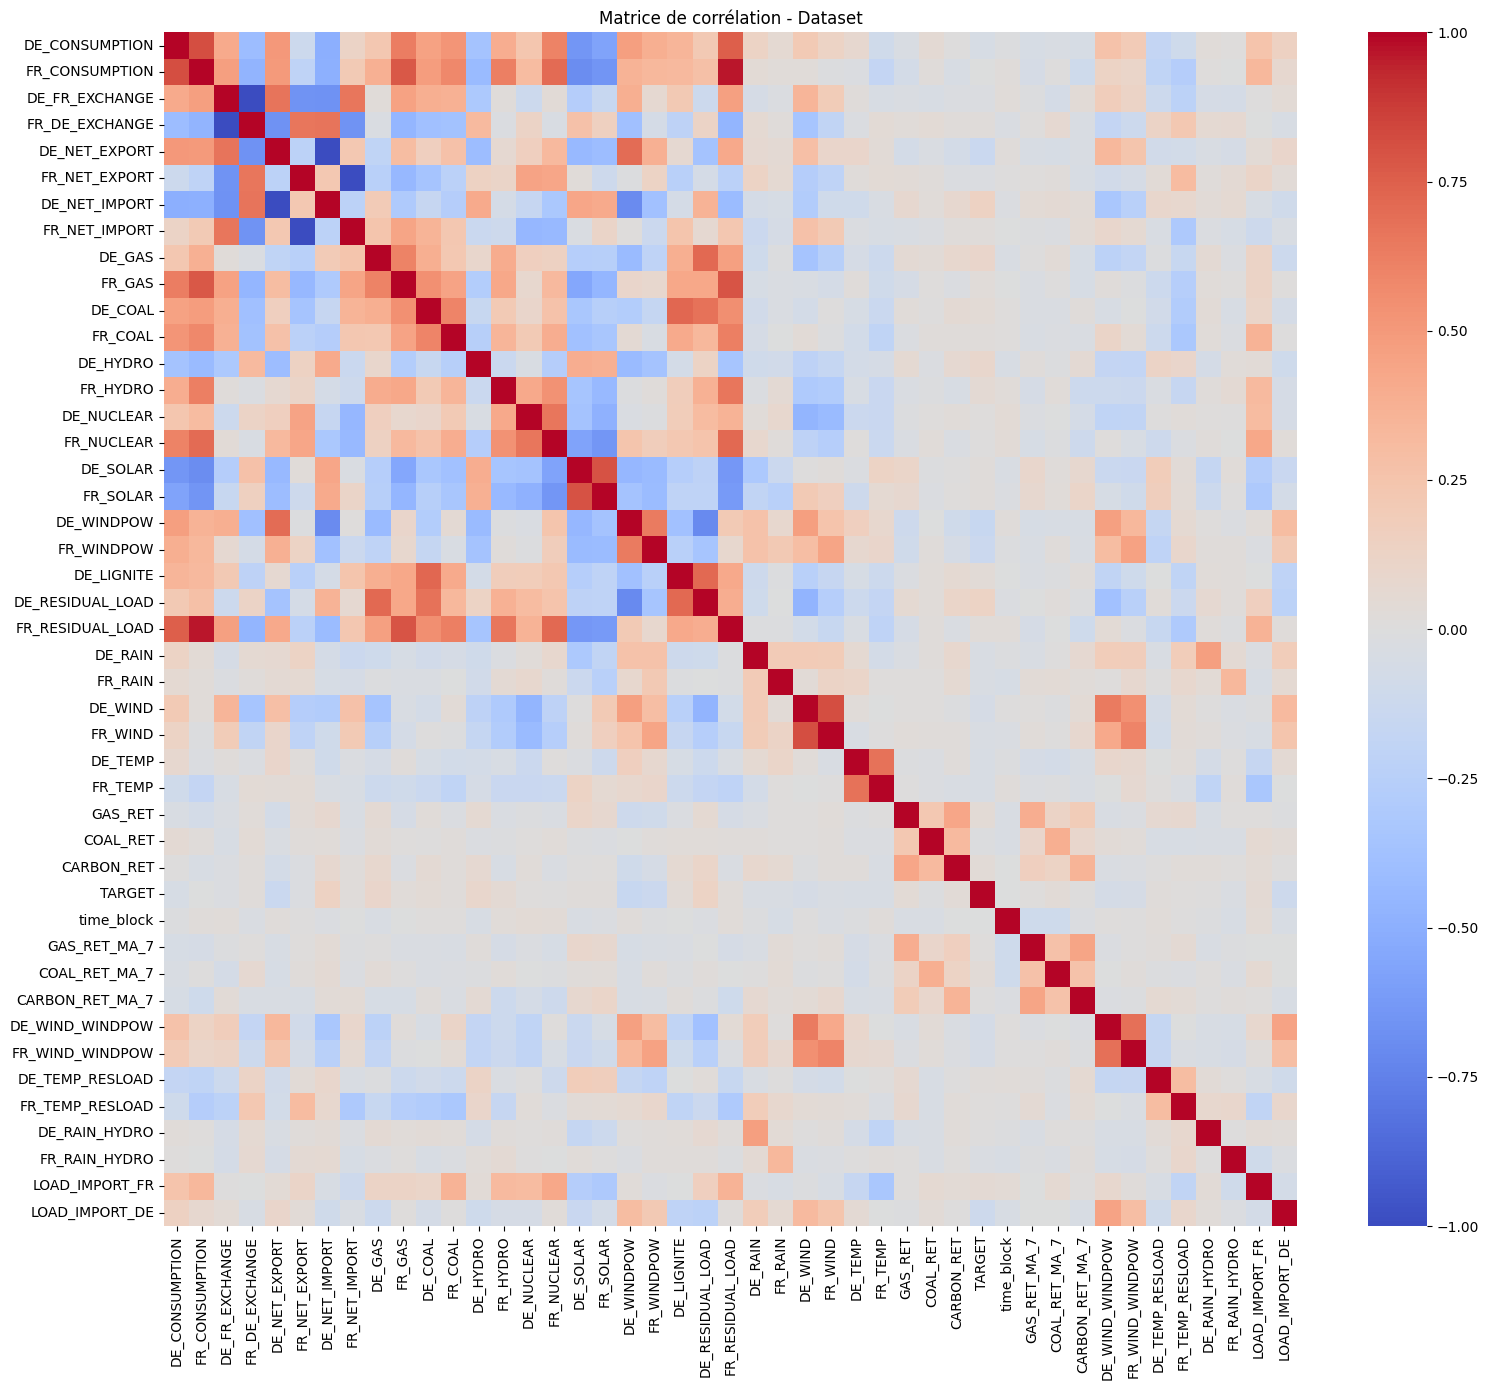

In [375]:
plt.figure(figsize=(16, 14))
numeric_cols = X_train.drop(columns=categorical_features + ['ID', 'DAY_ID', 'COUNTRY_DE', 'COUNTRY_FR'], errors='ignore')
sns.heatmap(numeric_cols.corr(), cmap="coolwarm", annot=False, fmt='.2f', cbar=True)
plt.title('Matrice de corrélation - Dataset')
plt.tight_layout()
plt.show()

In [376]:
# Trouver les colonnes à supprimer pour éviter la multicolinéarité
corr_matrix = numeric_cols.corr()
cols = corr_matrix.columns
cols_corr = []

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if abs(corr_matrix.iloc[i, j]) > 0.80:
            cols_corr.append((cols[i], cols[j]))

# Supprimer les doublons dans la liste
cols_corr = list(set(cols_corr))

print(f"Les features fortement corrélés sont (corrélation > 0.80):" )
print(cols_corr)

Les features fortement corrélés sont (corrélation > 0.80):
[('FR_NET_EXPORT', 'FR_NET_IMPORT'), ('DE_FR_EXCHANGE', 'FR_DE_EXCHANGE'), ('DE_NET_EXPORT', 'DE_NET_IMPORT'), ('DE_SOLAR', 'FR_SOLAR'), ('DE_WIND', 'FR_WIND'), ('DE_CONSUMPTION', 'FR_CONSUMPTION'), ('FR_CONSUMPTION', 'FR_RESIDUAL_LOAD')]


#### Commentaires : 
- certains feautures sont extrêment corrélés, nous allons donc en supprimer de notre dataset pour éviter la multicolinéarité: "FR_RESIDUAL_LOAD", "DE_SOLAR", "DE_CONSUMPTION", "DE_WIND", "DE_NET_EXPORT", "DE_FR_EXCHANGE", "FR_NET_EXPORT".
-   nous décidons de supprimer les données méthéorologiques allamandes et non françaises, puisque la majorité de nos target values concerent les variations de prix française, nous pensons donc que les données météorologiques françaises seront donc plus significatives en moyennes.
- Concernant les exportations et les importations, il s'agit du calcul net importation - exportation reporté sur les deux variables. Nous supprimons les exportations, ainsi lorsque la variable importation est positive : on importe, lorsque elle est negative on exporte.
- On garde le residual load, d'apres l'etat de l'art assez important 

In [377]:
cols_to_remove = ["FR_CONSUMPTION", "DE_SOLAR", "DE_CONSUMPTION", "DE_WIND", "DE_NET_EXPORT", "DE_FR_EXCHANGE", "FR_NET_EXPORT"]
X_tr = X_tr.drop(cols_to_remove, axis=1)
X_val = X_val.drop(cols_to_remove, axis=1)
X_test = X_test.drop(cols_to_remove, axis=1)

### Normalisation des données

Etant donné que on a plusieurs valeurs extremes il est necessaire de standariser les données. On fit le scaler sur X_tr uniquement, puis on l'applique de manière équivalente à X_tr et X_val.

In [378]:
from sklearn.preprocessing import StandardScaler

no_scale = ["COUNTRY"]
numeric_cols = [c for c in X_tr.columns if c not in no_scale]
# on fit le scaler sur train
scaler = StandardScaler()
scaler.fit(X_tr[numeric_cols])
# on transforme train et val
X_tr[numeric_cols] = scaler.transform(X_tr[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
# ne pas oublier de scaler aussi le test plus tard
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])



In [379]:
print(X_val.head())
print(X_tr.head())

      DAY_ID  COUNTRY  FR_DE_EXCHANGE  DE_NET_IMPORT  FR_NET_IMPORT    DE_GAS  \
7   2.467838        1        0.357119      -0.300726      -0.580856 -0.554307   
13  2.612266        0        1.261005       0.809770      -0.982593 -0.287860   
20  2.186389        0        0.872303       0.440690      -1.087618  0.098290   
28  2.645595        1       -0.479699       0.163769       0.343884 -1.010999   
38  1.945675        1       -1.083701       0.380457      -1.027234  1.058881   

      FR_GAS   DE_COAL   FR_COAL  DE_HYDRO  ...  FR_WIND_WINDPOW  \
7  -0.638435  1.162200  1.674105  1.185424  ...        -0.141329   
13 -1.228482 -1.232451 -0.041249 -0.043272  ...        -0.188356   
20 -0.342191 -0.528881  0.102182 -1.604398  ...         1.398117   
28  0.764458 -1.194355 -0.618551 -0.940943  ...         1.642441   
38  1.195351  2.935307  1.384838 -1.353631  ...        -0.147827   

    DE_TEMP_RESLOAD  FR_TEMP_RESLOAD  DE_RAIN_HYDRO  FR_RAIN_HYDRO  \
7          1.380311        -0.1551

Concernant le nombres de features, nous en avons 49, il faut essayer de reduire

### Correlation between Taget and Features

/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


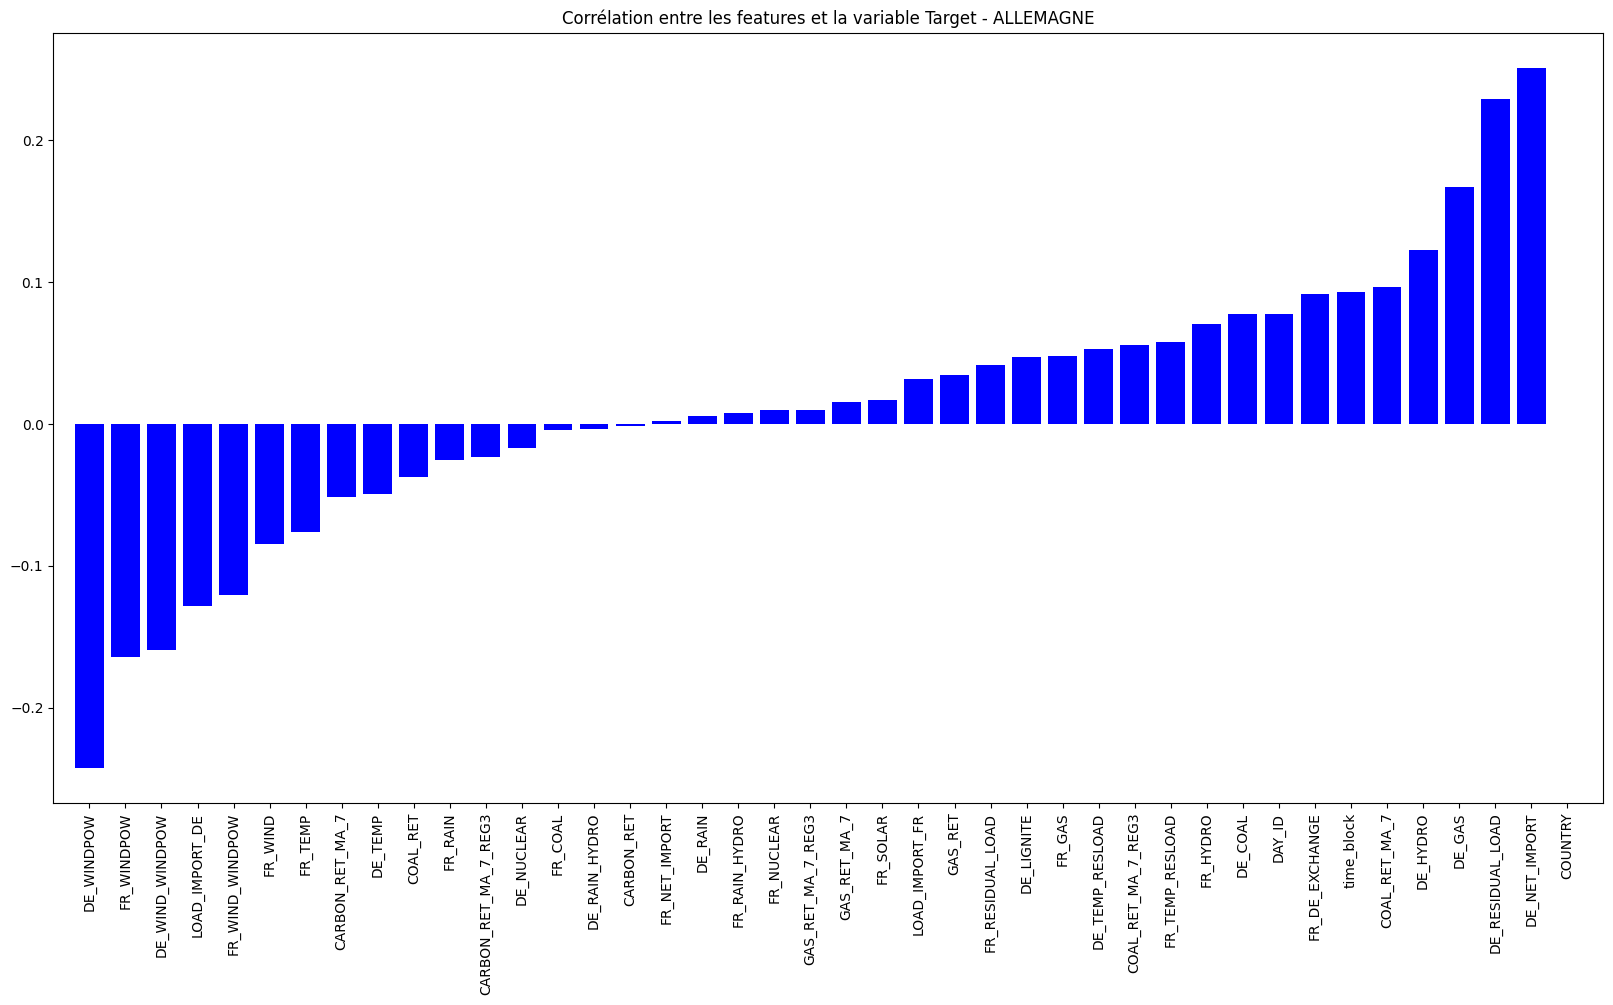

Variables avec |corrélation| > 0.2 (DE):
DE_WINDPOW         -0.242278
DE_RESIDUAL_LOAD    0.228842
DE_NET_IMPORT       0.250983
dtype: float64


In [380]:
# Corrélations pour l'Allemagne (DE)
X_DE_filtered = X_tr[X_tr['COUNTRY'] == 0]
y_DE_filtered = y_tr[y_tr.index.isin(X_DE_filtered.index)]

corr_matrix_DE = X_DE_filtered.corrwith(y_DE_filtered, method='pearson')
corr_matrix_DE = corr_matrix_DE.sort_values()

plt.figure(figsize=(20, 10))
plt.title("Corrélation entre les features et la variable Target - ALLEMAGNE")
plt.bar(range(len(corr_matrix_DE)), corr_matrix_DE, color="blue", align="center")
plt.xticks(range(len(corr_matrix_DE)), corr_matrix_DE.index, rotation='vertical')
plt.xlim([-1, len(corr_matrix_DE)])
plt.show()

print("Variables avec |corrélation| > 0.2 (DE):")
print(corr_matrix_DE[abs(corr_matrix_DE) > 0.2])

#### Commentaires:

- Les variables les plus corrélées avec les variations du prix de l'electricité allemandes sont : FR_COAL, DE_TEMP, COAL_RET, FR_TEMP, FR_HYDRO, DE_NUCLEAR, DE_HYDRO, FR_DE_EXCHANGE

/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


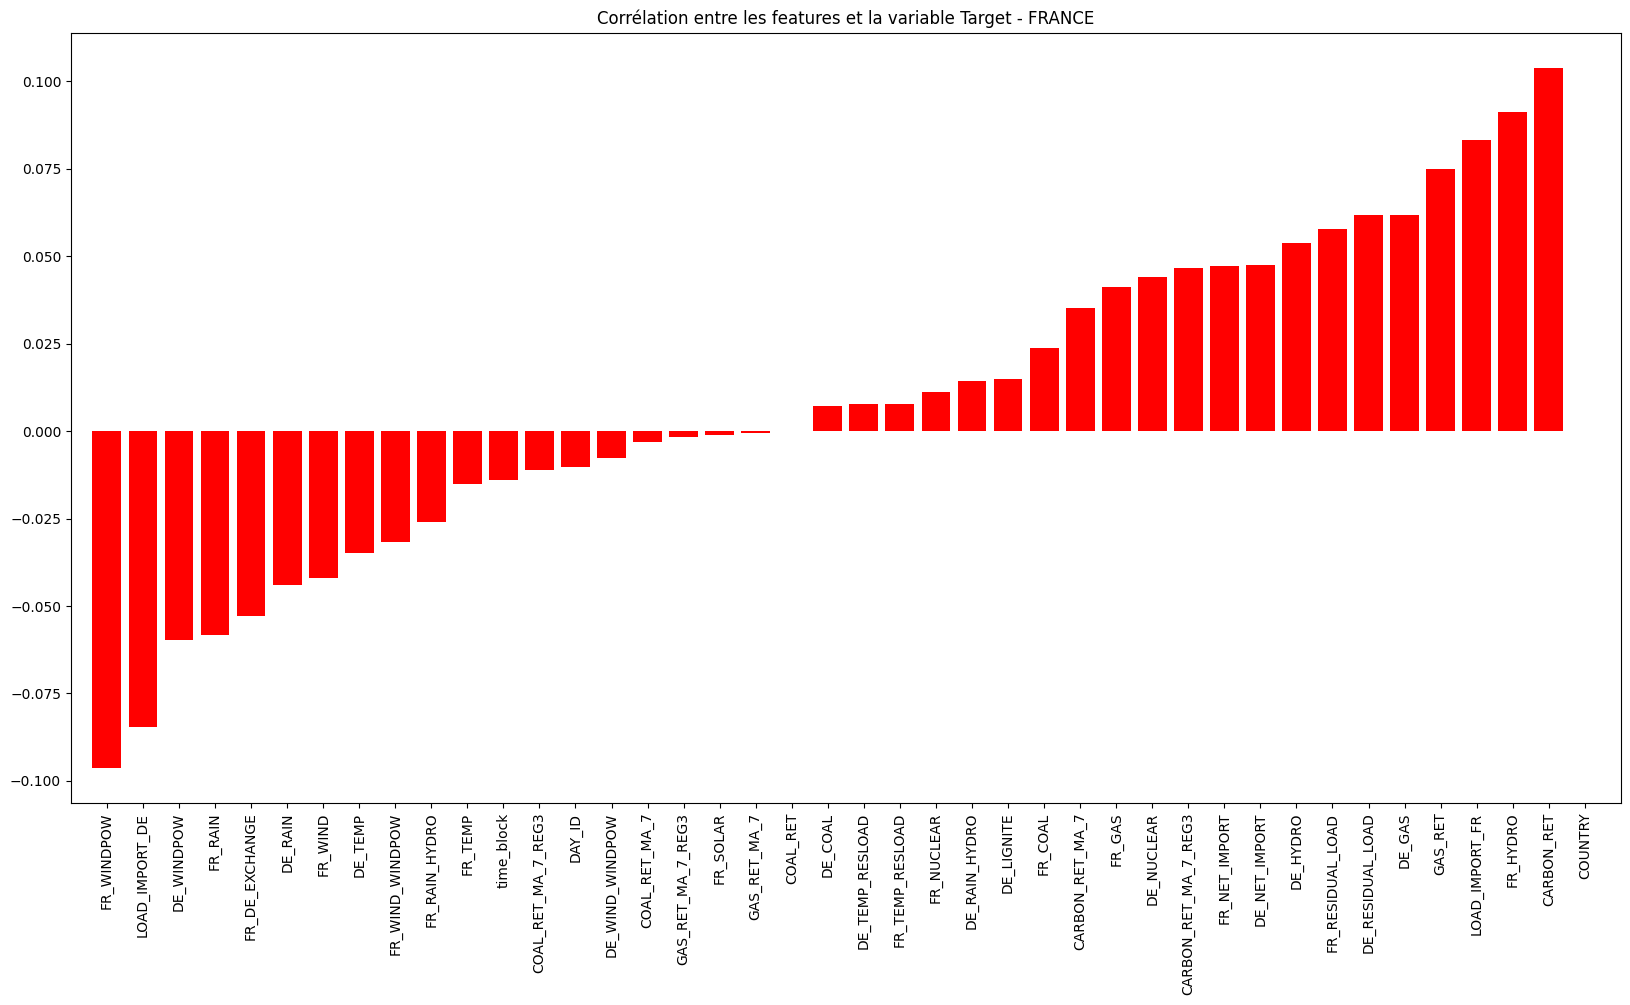

Variables avec |corrélation| > 0.2 (FR):
Series([], dtype: float64)


In [381]:
# Corrélations pour la France (FR)

X_FR_filtered = X_tr[X_tr['COUNTRY'] == 1]
y_FR_filtered = y_tr[y_tr.index.isin(X_FR_filtered.index)]

corr_matrix_FR = X_FR_filtered.corrwith(y_FR_filtered, method='pearson')
corr_matrix_FR = corr_matrix_FR.sort_values()
plt.figure(figsize=(20, 10))
plt.title("Corrélation entre les features et la variable Target - FRANCE")
plt.bar(range(len(corr_matrix_FR)), corr_matrix_FR, color="red", align="center")
plt.xticks(range(len(corr_matrix_FR)), corr_matrix_FR.index, rotation='vertical')
plt.xlim([-1, len(corr_matrix_FR)])
plt.show()

print("Variables avec |corrélation| > 0.2 (FR):")
print(corr_matrix_FR[abs(corr_matrix_FR) > 0.2])

#### Commentaires:

- Les variables les plus corrélées avec les variations du prix de l'electricité allemandes sont : FR_COAL, CARBON_RET, DE_RESIDUAL_LOAD

## Regression lineaire

Les prix de l’électricité ont des pics violents et imprévisibles donc une erreur de +50 €/MWh d'estimations est bien plus grave qu’une erreur de +5, donc nous utilisons le RMSE qui penalise fortement les grosses erreurs.

cf Day-Ahead electricity price forecasting.pdf

In [335]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X_tr, y_tr)


LinearRegression()

In [336]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred_tr = ols.predict(X_tr)
y_pred_val = ols.predict(X_val)

results_ols = {
    "RMSE_train": np.sqrt(mean_squared_error(y_tr, y_pred_tr)),
    "RMSE_val": np.sqrt(mean_squared_error(y_val, y_pred_val)),
    "R2_train": r2_score(y_tr, y_pred_tr),
    "R2_val": r2_score(y_val, y_pred_val)
}

results_ols

/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/li

{'RMSE_train': np.float64(1.018529055995745),
 'RMSE_val': np.float64(0.9315970152951936),
 'R2_train': 0.07861394320771009,
 'R2_val': -0.03584724587845911}

In [217]:
y_tr.describe()

count    1194.000000
mean        0.109836
std         1.061536
min        -6.519268
25%        -0.208531
50%         0.000000
75%         0.248091
max         7.786578
Name: TARGET, dtype: float64

La variable target  se concentre autour de zéro, avec un écart-type de 1 enviton, mais également des valeurs extrêmes atteignant ±7. Le RMSE obtenu sur l’échantillon de validation (≈0.93) est du même ordre de grandeur que l’écart-type de la série, indiquant que le modèle linéaire ne parvient pas à réduire significativement la variance du prix.
Sur 75 % des jours, Y est entre −0.21 et +0.25, une erreur de 0.9 est énorme relativement. 
Ceci se traduit par un coefficient de détermination négatif sur l’échantillon de validation. Ce comportement est typique des modèles linéaires appliqués aux prix de l’électricité, dont la dynamique est fortement non linéaire et dominée par des épisodes de volatilité extrême.

## 2. Modèle - Regression (Lasso, Ridge and Elastic Net)

In [218]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

Pour le modele lasso, on effectue une cross validation pour trouver le parametre alpha optimal

In [337]:
lasso = Lasso(max_iter=20000, random_state=42)

param_grid = {
    "alpha": np.logspace(-4, 2, 30)   # 1e-4 -> 1e2, assez standard
}

search = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",  # RMSE (négatif car convention sklearn)
    n_jobs=-1
)

search.fit(X_tr, y_tr)

best = search.best_estimator_

/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/li

In [338]:
pred_va = best.predict(X_val)

rmse_va = np.sqrt(mean_squared_error(y_val, pred_va))
mae_va = mean_absolute_error(y_val, pred_va)
r2_va = r2_score(y_val, pred_va)

print("Meilleur alpha :", search.best_params_["alpha"])
print("RMSE CV train  :", -search.best_score_)
print("Validation : RMSE:", rmse_va, "R2:", r2_va)

Meilleur alpha : 0.03039195382313198
RMSE CV train  : 1.047806073686337
Validation : RMSE: 0.9068235255256857 R2: 0.018511770706025055


/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [389]:
Y_test_submission = X_test[['ID']].copy()
X_test_clean= X_test.drop(columns=["ID"], errors="ignore")
Y_test_submission['TARGET'] = best.predict(X_test_clean)
Y_test_submission.to_csv('benchmark_qrt.csv', index=False)

/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [390]:
#download file

import shutil
shutil.move('benchmark_qrt.csv', '../data/benchmark_qrt.csv')


'../data/benchmark_qrt.csv'

Nous avons a peu pres le meme resultat que la regression lineaire ce qui n'est pas etonnant

## 3. Modèle - Random Forest Regressor

Nous avons un probleme de prevision de prix de l'electricité, avec des relations non lineaires comme nous l'avons vu, pas mal de correlation, des jours extremes. Random forest est un bon choix de model ensembliste car il est robuste au bruit et a la multicolinarité 

In [391]:

from sklearn.ensemble import RandomForestRegressor


#Modèle + grille d'hyperparamètres

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [300, 600],          # nb d'arbres
    "max_depth": [None, 6, 12, 20],      # profondeur (None = illimité)
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.5, 0.8]   # nb de features testées à chaque split
}

search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",  # RMSE
    n_jobs=-1,
    verbose=1
)

search.fit(X_tr, y_tr)

best_rf = search.best_estimator_

print("Meilleurs hyperparamètres :", search.best_params_)
print("RMSE (CV train) :", -search.best_score_)


#Évaluation sur validation (hold-out)

pred_va = best_rf.predict(X_val)

rmse_va = np.sqrt(mean_squared_error(y_val, pred_va))
mae_va = mean_absolute_error(y_val, pred_va)
r2_va = r2_score(y_val, pred_va)

print("Validation -> RMSE:", rmse_va, "MAE:", mae_va, "R2:", r2_va)


importances = pd.Series(best_rf.feature_importances_, index=X_tr.columns)\
               .sort_values(ascending=False)

print("\nTop 15 features :")
display(importances.head(15))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

## 3. Modèle - Réseau de Neurone

In [ ]:
y_val

7       0.112850
13     -0.025477
20      0.012715
28      1.327686
38     -0.019036
          ...   
1477    0.978182
1486    0.827636
1491    0.151797
1492   -0.640917
1493   -0.252764
Name: TARGET, Length: 300, dtype: float64

In [382]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y en vecteur 1D
ytr = y_tr.values.ravel()
yva = y_val.values.ravel()


mlp = MLPRegressor(
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    max_iter=3000
)

param_grid = {
    "hidden_layer_sizes": [(32,), (64,), (64, 32)],
    "alpha": [1e-5, 1e-4, 1e-3],
    "learning_rate_init": [1e-3, 3e-4],
}

gs = GridSearchCV(
    mlp,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",   # MSE (compatible partout)
    n_jobs=-1
)

gs.fit(X_tr, ytr)

best_mlp = gs.best_estimator_
pred_val = best_mlp.predict(X_val)

mse_val = mean_squared_error(yva, pred_val)
rmse_val = np.sqrt(mse_val)            
mae_val = mean_absolute_error(yva, pred_val)
r2_val = r2_score(yva, pred_val)

rmse_cv = np.sqrt(-gs.best_score_)     

print("Meilleurs hyperparamètres :", gs.best_params_)
print("RMSE (CV train) :", rmse_cv)
print(f"Validation -> RMSE: {rmse_val:.6f}  MAE: {mae_val:.6f}  R2: {r2_val:.6f}")



/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-

Meilleurs hyperparamètres : {'alpha': 1e-05, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.0003}
RMSE (CV train) : 1.104258587758582
Validation -> RMSE: 0.947507  MAE: 0.623899  R2: -0.071530


/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-

In [388]:
Y_test_submission = X_test[['ID']].copy()
X_test_clean= X_test.drop(columns=["ID"], errors="ignore")
Y_test_submission['TARGET'] = best_mlp.predict(X_test_clean)
Y_test_submission.to_csv('benchmark_qrt.csv', index=False)
import shutil
shutil.move('benchmark_qrt.csv', '../data/benchmark_qrt.csv')


/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/taniaadmane/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


'../data/benchmark_qrt.csv'

In [385]:
Y_test_submission

ID
231   410
570   562
199   750
202   802
203   504
..    ...
631  1726
336  1355
89   1668
341  1486
1    1202

[654 rows x 1 columns]